# Draw

In [49]:
import numpy  as np
from copy import copy

import random
import math
import itertools
from more_itertools import pairwise

from random import random, shuffle, uniform, randint
from io import BytesIO

import cairo
import IPython.display
import PIL
import PIL.Image
import PIL.ImageFilter

In [50]:
XMAX = 100
XMIN = -95

YMAX = 185
YMIN = -90

XMID = (XMAX + XMIN) / 2.0
YMID = (YMAX + YMIN) / 2.0

PEN_DELAY = 125

START_X = 0
START_Y = -200

In [51]:
def clamp(value, min_value, max_value):
    return min(max(value, min_value), max_value)

In [52]:
class GCODE:
    def __init__(self, name="foobar", feedrate=1000):
        self.start_pos = np.array([START_X, START_Y])
        self.pos = copy(self.start_pos)
        self.f = open(f"{name}.gcode", "wt")
        self.feedrate = feedrate
        
        self.servo = "P0"
        self.pen_up_pos = "S0"
        self.pen_down_pos = "S90"
         
        self.f.write("M17\n")  # Ensure steppers are enabled
        self.f.write("M121\n")  # Disable endstops, just in case
        self.f.write("G90\n")  # Set absolute positioning
        self.f.write("; potatolangelo\n")
        self.pen_up()
        self.move_to_starting_position()
        
    def pen_up(self):
        self.finish_moves()
        self.f.write(f"M280 {self.servo} {self.pen_up_pos} T{PEN_DELAY}\n")
    
    def pen_down(self):
        self.finish_moves()
        self.f.write(f"M280 {self.servo} {self.pen_down_pos} T{PEN_DELAY}\n")
        
    def finish_moves(self):
        self.f.write("M400\n")
        
    def move_to(self, x, y, feedrate=None):
        feedrate = feedrate or self.feedrate
        
        x = clamp(x, XMIN, XMAX)
        y = clamp(y, YMIN, YMAX)
        
        self.pos[0] = x
        self.pos[1] = y
        
        self.f.write(f"G0 X{x} Y{y} F{feedrate}\n")
        
    def move_to_mid_point(self, feedrate=None):
        self.move_to(XMID, YMID, feedrate=feedrate)
        
    def move_to_starting_position(self, feedrate=None):
        self.move_to(START_X, START_Y, feedrate=feedrate)
        
    def step(self, dx, dy, feedrate=None):
        feedrate = feedrate or self.feedrate
        self.pos[0] += dx
        self.pos[1] += dy
        
        x = self.pos[0]
        y = self.pos[1]
        x = clamp(x, XMIN, XMAX)
        y = clamp(y, YMIN, YMAX)
        self.pos[0] = x
        self.pos[1] = y
        
        self.f.write(f"G0 X{x} Y{y} F{feedrate}\n")
        
    def square_filled(self, xmin, ymin, xmax, ymax, dy=1, zigzag=True):
#         print(f"square filled centered on {(xmin + xmax) / 2.0:.2f} {(ymin + ymax) / 2.0:.2f}")
        
        self.pen_up()    
        self.move_to((xmin + xmax) / 2.0, (ymin + ymax) / 2.0)
        
        self.square(xmin, ymin, xmax, ymax)
        
        self.pen_up()    
        self.move_to(xmin, ymin)
        self.pen_down()
        
        x = xmin
        y = ymin
        while y < ymax:
            y += dy
            
            # When zigzag is true the pen moves in a saw tooth pattern,
            # otherwise it goes in a square wave form.
            # Zigzag looks good with ballpoint pens, while the square pattern
            # works best on thicker points.
            if not zigzag:
                self.move_to(x, y)
            
            if x == xmin:
                x = xmax
            else:
                x = xmin
                
            self.move_to(x, y)
            
        self.pen_up()
                
    def square(self, xmin, ymin, xmax, ymax):
        return
        self.move_to(xmin, ymin)
        self.pen_down()
        self.move_to(xmax, ymin)
        self.move_to(xmax, ymax)
        self.move_to(xmin, ymax)
        self.move_to(xmin, ymin)
        self.pen_up()
            
    def flush(self):
        self.f.flush()

# The drawing algo

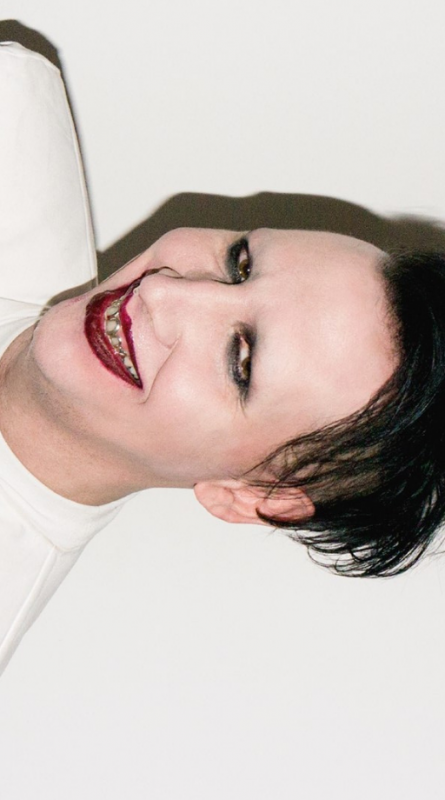

In [53]:
image_name = "cutie.png"
# image_name = "hack.png"
# image_name = "squares.jpg"
# image_name = "full-moon-with-face.png"

IPython.display.Image(filename=image_name) 

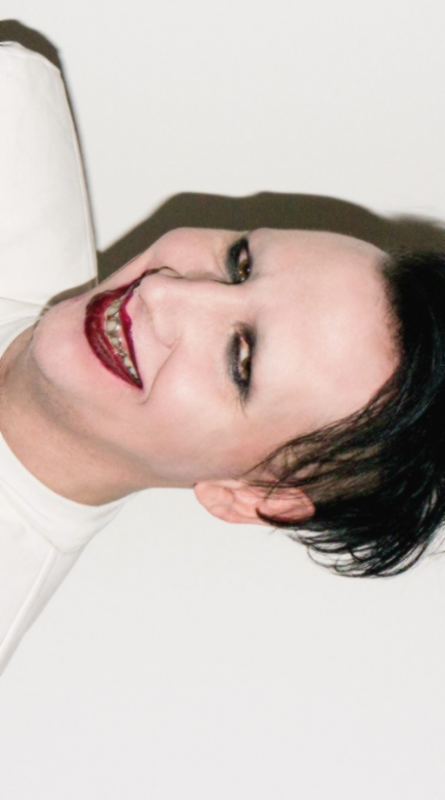

In [54]:
original_image = PIL.Image.open(image_name)
image = copy(original_image)

width = original_image.width
height = original_image.height

scale = 1

image = image.resize((int(width / scale), int(height / scale)), PIL.Image.ANTIALIAS)

# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
# image = image.filter(PIL.ImageFilter.SMOOTH_MORE)
# image = image.filter(PIL.ImageFilter.SMOOTH_MORE)

# image = image.filter(PIL.ImageFilter.CONTOUR)
# image = image.filter(PIL.ImageFilter.CONTOUR)

# image = image.filter(PIL.ImageFilter.DETAIL)

image = image.filter(PIL.ImageFilter.SMOOTH_MORE)
# image = image.filter(PIL.ImageFilter.CONTOUR)

# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE)

# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)

# image = image.rotate(90)

image = image.convert("RGB")

IPython.display.display(image)

In [55]:
points = []

width = image.width
height = image.height

block_size = 10

for by in range(0, height, block_size):
    for bx in range(0, width, block_size):
        block_intensity = 0
        pixels_read = 0
        
        for y_offset in range(0, block_size):
            for x_offset in range(0, block_size):
                x = bx + x_offset
                y = by + y_offset
                if x > width -1 or y > height - 1:
                    continue

                r, g, b = image.getpixel((x, y))
                intensity = ((255 - r) + (255 - g) + (255 - b)) / (255 * 3.0)
                
                block_intensity += intensity
                pixels_read += 1
                
            block_intensity /= pixels_read
            points.append(block_intensity)
            
            
len(points)

36000

In [56]:
basename = "hack"

gcode = GCODE(basename, feedrate=1000)
gcode.move_to_starting_position()

gcode.pen_down()

for y in range(int(height / block_size)):
    for x in range(int(width / block_size)):
        index = x + y * block_size
        intensity = points[index]
        dy = (1.01 - (intensity / 255.0)) * 5.0
        gcode.square_filled(
            x * block_size, 
            y * block_size, 
            (x + 1) * block_size, 
            (y + 1) * block_size, 
            dy=dy,
        )

gcode.pen_up()

gcode.move_to_starting_position()
gcode.flush()

# Preview

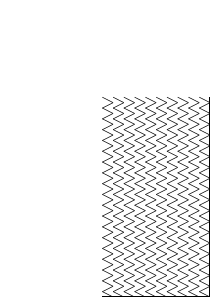

In [57]:
svgio = BytesIO()
filename = f"{basename}.gcode"

last_x = (START_X - XMIN) / (XMAX - XMIN)
last_y = (START_Y - YMIN) / (YMAX - YMIN)

width = 210
height = 297

drawing = False

with cairo.SVGSurface(svgio, width, height) as surface, open(filename) as f:
    context = cairo.Context(surface)
    context.scale(width, height)
    context.set_line_width(0.0025)
    context.set_source_rgba(0, 0, 0, 1)
    
    for line in f.readlines():
        if "G0" in line:
                
            tokens = line.strip().split(" ")[1:]
            x = (float(tokens[0][1:]) - XMIN) / (XMAX - XMIN)
            y = (float(tokens[1][1:]) - YMIN) / (YMAX - YMIN)

            if writing:  
                context.move_to(last_x, last_y)
                context.line_to(x, y)
                context.stroke()

            last_x = x
            last_y = y
            
        if "M280 P0" in line:
            tokens = line.strip().split(" ")[1:]
            if tokens[1] == "S0":
                writing = False
            elif tokens[1] == "S90":
                writing = True

IPython.display.SVG(data=svgio.getvalue())